In [0]:
import keras
from keras import backend as K

In [0]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np
#encoder network
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2

input_img = keras.Input(shape=img_shape)

#creating covnet
x = layers.Conv2D(32,3,
                 padding = 'same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                 padding='same', activation='relu',
                 strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                 padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                 padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)


In [0]:
def sampling(args):
  z_mean, z_log_var = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                           mean=0., stddev=1.)
  return z_mean + K.exp(z_log_var) * epsilon
#introducing pramaters
z = layers.Lambda(sampling)([z_mean, z_log_var])

In [0]:
decoder_input = layers.Input(K.int_shape(z)[1:])
#reshaping the vector z

x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)


x = layers.Reshape(shape_before_flattening[1:])(x)

x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', activation='sigmoid')(x)
decoder = Model(decoder_input, x)

z_decoded = decoder(z)

In [0]:
class CustomVariationalLayer(keras.layers.Layer):
  #creating the custom layer
    def vae_loss(self, x, z_decoded):
      x = K.flatten(x)
      z_decoded = K.flatten(z_decoded)
      xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
      kl_loss = -5e-4 * K.mean(
          1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
      return K.mean(xent_loss + kl_loss)
  
    def call(self, inputs):
      x = inputs[0]
      z_decoded = inputs[1]
      loss = self.vae_loss(x, z_decoded)
      self.add_loss(loss, inputs=inputs)
      return x

  
  
y = CustomVariationalLayer()([input_img, z_decoded])

In [0]:
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
       shuffle=True,
       epochs=10,
       batch_size=batch_size,
       validation_data=(x_test,None))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 28, 28, 32)   320         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 14, 14, 64)   18496       conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 14, 14, 64)   36928       conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_12 

/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:408: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:918: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/usr/local/lib/python3.6/dist-packages/numpy/ma/core.py:713: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


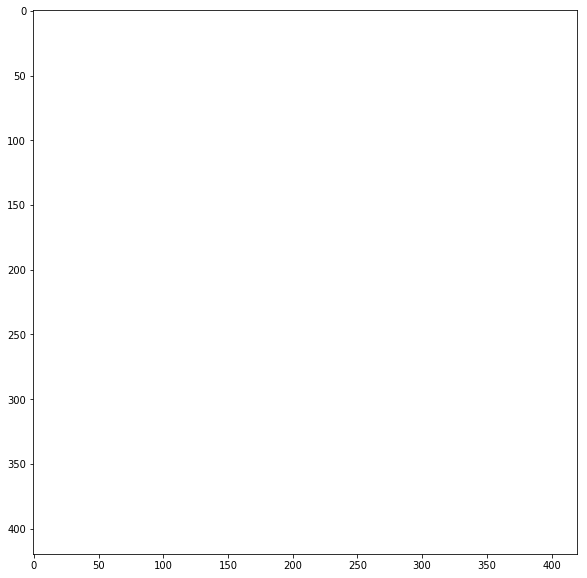

In [0]:
import matplotlib.pyplot as plt
from scipy.stats import norm
#creating the grid
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

#enumeration and analyzation of images
for i, yi in enumerate(grid_x):
  for j, xi in enumerate(grid_y):
    z_sample = np.array(([xi, yi]))
    z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
    x_decoded = decoder.predict(z_sample, batch_size=batch_size)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size,
          j * digit_size: (j + 1) * digit_size] = digit
    #ploting the figure
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()